### Load required libraries

In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns

### Retrieve preprocessed drawing session metadata

In [2]:
## define some paths
top_level_dir = '/home/jefan/kiddraw'
path_to_preprocessed_data = 'analysis/museumdraw/preprocessed_data/museumdraw_E1cd_data.csv'

## load in preprocessed csv
x = pd.read_csv(os.path.join(top_level_dir,path_to_preprocessed_data))
x = x.drop(['Unnamed: 0'], axis=1)
print 'Number of sketches in metadata = {}'.format(np.shape(x)[0])
metadata_sketch_count = np.shape(x)[0]

Number of sketches in metadata = 467


### Load VGG feature analysis libraries and scripts

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [31]:
# Retrieve sketch paths -- pngs rendered out in another step
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = '/home/jefan/kiddraw/analysis/museumdraw/sketches'
sketch_paths = sorted(list_files(path_to_sketches))

## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

png_sketch_count = len(sketch_paths)


Number of sketch paths = 467


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [32]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/jefan/kiddraw/analysis/museumdraw/python/features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

In [57]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6

## load in kid features
KF, KM = load_features('kid',layer_ind)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

Number of unique kids who contributed drawings = 66
Number of features for 462 images in layer 6 = 4096


In [58]:
## Check that we have the right number of skethces
numInvalidSketches = 5 ## see invalid_sketches .txt file
assert(feature_sketch_count == png_sketch_count - numInvalidSketches) # features get rid of some invalid sketches
assert(metadata_sketch_count == png_sketch_count) # these should be the same

### Separate drawings according to the coarse age of the child

In [59]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)

In [60]:
## subset labels that have at least some drawings of them from each age category
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values

## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(younger_labels,older_labels))

print 'We have {} labels that are common to both younger and older kid cohorts.'.format(len(common_labels))

We have 37 labels that are common to both younger and older kid cohorts.


In [61]:
def subset_labels(F,M, labels):
    '''
    if labels == common_labels, then only include labels that are common to younger and older cohort
    if labels == sufficient_data_labels, then subset by list of labels in which we have 'sufficient data', i.e., have >=thresh drawings/class
    '''
    _F = F[M['label'].isin(labels),:]
    _M = M[M['label'].isin(labels)]
    return _F, _M

## get list of labels in which we have 'sufficient data', i.e., have >=3 drawings/class
thresh = 3
sufficient_data_labels = [] 
for cl in common_labels:
    num_young_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='younger')[0])
    num_older_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='older')[0])
    if (num_young_sketches>=thresh) & (num_older_sketches>=thresh):
        sufficient_data_labels.append(cl)        
       
print 'We have {} classes with sufficient data.'.format(len(sufficient_data_labels))


We have 27 classes with sufficient data.


In [62]:
## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
KF, KM = subset_labels(KF, KM, sufficient_data_labels)
KM = KM.reset_index(drop=True)

## output final number of drawings
older=KM[KM['coarse_age'] == 'older']
younger=KM[KM['coarse_age'] == 'younger']

print 'We have {} drawings in the older cohort'.format(np.shape(older)[0])
print 'We have {} drawings in the younger cohort'.format(np.shape(younger)[0])


We have 205 drawings in the older cohort
We have 191 drawings in the younger cohort


In [63]:
## Load sets for older vs. younger children
ind = KM.index[KM['coarse_age'] == 'older']
KM_older = KM.loc[ind]
KF_older = KF[ind.tolist()]

ind2 = KM.index[KM['coarse_age'] == 'younger']
KM_younger = KM.loc[ind2]
KF_younger = KF[ind2.tolist()]

#### Get distribution of drawings across label and coarse age category 

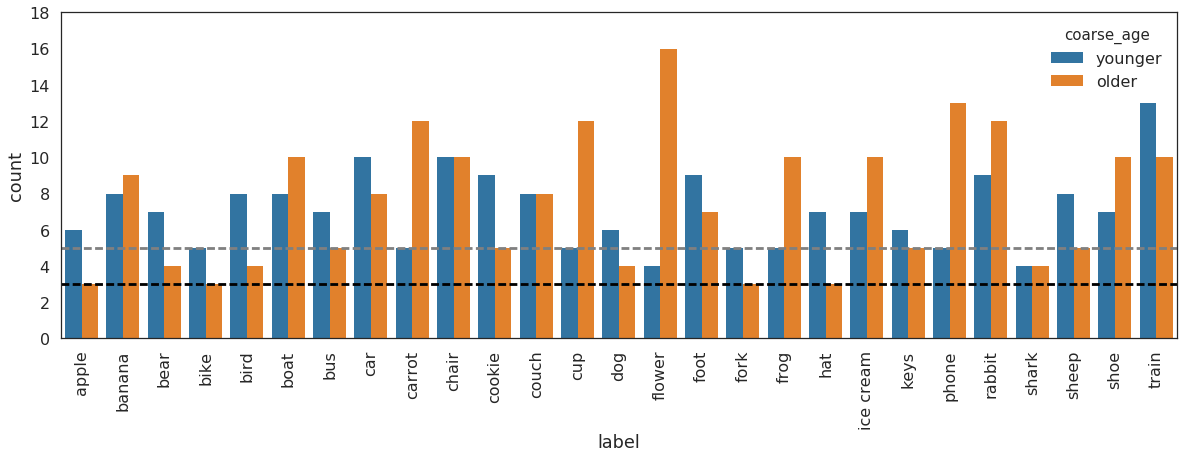

In [64]:
sns.set_context('poster')
plt.figure(figsize=(20,6))
sns.countplot(data=KM,
           x='label',
           hue='coarse_age')
labels = np.unique(KM.label.values)
h = plt.xticks(range(len(labels)), labels, fontsize=16,rotation='vertical')
plt.axhline(3,linestyle='dashed',color='black')
plt.axhline(5,linestyle='dashed',color='gray')
plt.ylim(0,18)
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/drawing_counts_by_label_and_coarse_age.pdf', bbox_inches="tight")

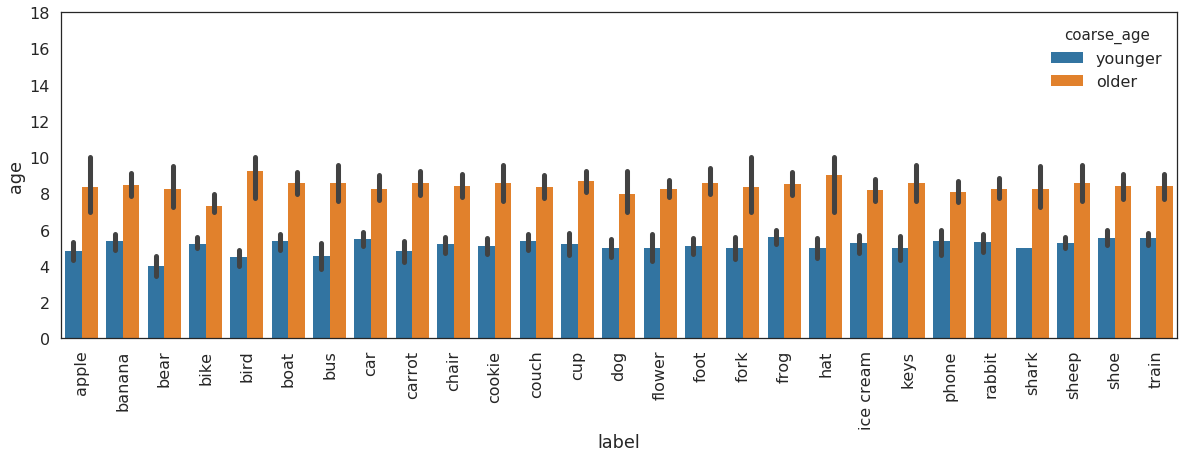

In [65]:
sns.set_context('poster')
plt.figure(figsize=(20,6))
ax = sns.barplot(x="label", y="age", hue='coarse_age',data=KM)

labels = np.unique(KM.label.values)
h = plt.xticks(range(len(labels)), labels, fontsize=16,rotation='vertical')
plt.ylim(0,18)
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/distribution_of_age_by_label.pdf', bbox_inches="tight")

In [66]:
## print list of classes for which we have "fewer than X" drawings in each age cohort and were thus excluded
thresh = 3
labels = np.unique(KM.label.values)
age_bins = ['younger','older']
labels_in_need = []
y_counter = []
o_counter = []
for lab in labels:
    y_count = sum(KM[KM['label']==lab]['coarse_age'] == 'younger')
    o_count = sum(KM[KM['label']==lab]['coarse_age'] == 'older')
    if (y_count<=thresh) | (o_count<=thresh):
        labels_in_need.append(lab)
        y_counter.append(y_count)
        o_counter.append(o_count)
o = pd.DataFrame([labels_in_need,y_counter,o_counter])
o = o.transpose()
o.columns = ['label','younger','older']
o = o.sort_values(by=['younger','older'],ascending=False)
o

,label,younger,older
3,hat,7,3
0,apple,6,3
1,bike,5,3
2,fork,5,3


### Extract adult drawing features

In [67]:
def load_adult_features(layer_ind,sufficient_data_labels):
    ## load in adult features
    AF, AM = load_features('adult',layer_ind)
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)
    
    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(sufficient_data_labels,sufficient_data_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in sufficient_data_labels])
    AM = AM.reset_index(drop=True)  
    
    return AF, AM

## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

In [68]:
AF, AM = load_adult_features(layer_ind,sufficient_data_labels)

### Get sorting indexes for ploting RMDS

In [69]:
## Load layer 6 features for adults and use these to sort
AF_S, AM_S = load_adult_features(6,sufficient_data_labels)

## retrieve alpha sorted labels from meta
_labels = np.unique(AM_S.label.values)
means = get_class_means(AF_S, AM_S.label.values)
af = AffinityPropagation(damping=0.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['apple']
['bus' 'car' 'train']
['carrot' 'chair' 'fork' 'ice cream']
['cookie']
['banana' 'bear' 'bicycle' 'bird' 'boat' 'dog' 'flower' 'frog' 'keys'
 'rabbit' 'shark' 'sheep']
['couch' 'cup' 'foot' 'hat' 'phone' 'shoe']


### Representational Similarity Analyses

In [123]:
def get_and_plot_RDM(M,F,cohort,sort_inds, layer_ind):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)

    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-CORRMAT, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(cohort, layer_ind), bbox_inches="tight")
    plt.savefig('./outputs-cogsci/RDM_{}_Layer_{}.pdf'.format(cohort, layer_ind), bbox_inches="tight")
    return RDM

def showRDM(RDM,ordered_objs):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  

def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

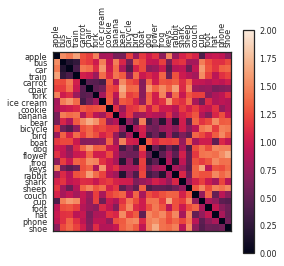

In [124]:
## get and plot sorted adult RDM
ARDM = get_and_plot_RDM(AM, AF,'adult',sort_inds,layer_ind)

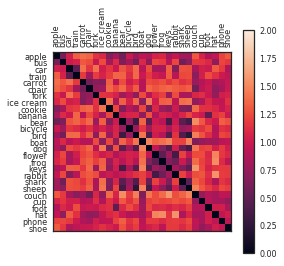

In [125]:
## get and plot sorted kid RDM collapsing across all ages
KRDM = get_and_plot_RDM(KM, KF,'kid',sort_inds,layer_ind)

In [ ]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
ORDM = get_and_plot_RDM(meta, feat,'older',sort_inds,layer_ind)

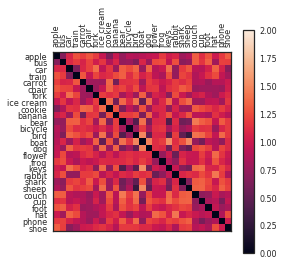

In [76]:
## get RDM for younger kids (3,4,5,6)
ind = KM.index[KM['coarse_age'] == 'younger']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
YRDM = get_and_plot_RDM(meta, feat,'younger',sort_inds,layer_ind)

In [77]:
## print fc7 cross-cohort correlations
dim = KRDM.shape[0]
cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and overall kid RDM: {}'.format(cor)
print ' '
dim = ORDM.shape[0]
cor = stats.spearmanr(np.ravel(ORDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and OLDER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and YOUNGER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ORDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between OLDER and YOUNGER kid RDM: {}'.format(cor)

Correlation between adult and overall kid RDM: 0.550771173271
 
Correlation between adult and OLDER kid RDM: 0.640146797647
 
Correlation between adult and YOUNGER kid RDM: 0.372084859585
 
Correlation between OLDER and YOUNGER kid RDM: 0.604570984571


### How does similarity differ across layers?

#### Set variables, paths, and define preprocessing functinos

In [79]:
## which label set are we using? common_labels or sufficient_data_labels
these_labels = sufficient_data_labels

## make sure directory for RDM exists
if not os.path.exists('./rdm'):
    os.makedirs('./rdm')

## function to apply various cleanup operations to adult feat/meta, including deborkifying and subsetting by appropriate labelset
def adult_preproc(AF, AM, these_labels):
    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(these_labels,these_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
    AM = AM.reset_index(drop=True)    
    return AF, AM

## function to add coarse grain age and subset according to proper labelset
def preproc_kid(KF, KM,these_labels):    
    KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)
    ## subset labels that have at least some drawings of them from each age category
    younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
    older_labels = KM[KM['coarse_age'] == 'older']['label'].values
    
    ## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
    KF, KM = subset_labels(KF, KM, these_labels)
    KM = KM.reset_index(drop=True)    
    return KF, KM


def get_RDM_resampled(M,F,sort_inds,iteration):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:] 
    ### JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
    # 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
    # 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
    #          where x.i = (1/n) * Sum(xi), the average of all subsamples    
    jacks = np.roll(range(ordered_means.shape[0]),iteration)[:ordered_means.shape[0]-1]
    ordered_means = ordered_means[jacks,:]
    RDM = np.corrcoef(ordered_means)
    return RDM

def get_rdm_similarity(A,B):
    '''
    A is RDM for one population
    B is RDM for another population, of same dimensionality
    '''
    dim = A.shape[0]
    return stats.spearmanr(np.ravel(A[np.triu_indices(dim,k=1)]),np.ravel(B[np.triu_indices(dim,k=1)]))[0]

def subsample_rdm(RDM,i):
    '''
    If you have a 16 objects x 16 objects RDM, and want to remove one of the objects,
    yielding a 15x15 RDM, in order to compare to a jackknife RDM, apply this function.
    
    Generally speaking, it removes the i-th colum and row from the RDM.

    '''
    num_obj = RDM.shape[0]
    keep = sorted(np.roll(range(num_obj),i)[:num_obj-1])
    tmp = RDM[keep,:]
    tmp = tmp[:,keep]   
    return tmp



### Get varilaibty across classes

##### Generate and save out RDMs as separate npy files for adults

In [80]:
# really run or not
really_run = 1

if really_run:
    for layer_num in np.arange(7):
        print 'Loading in adult features for layer {}...'.format(layer_num)
        AF, AM = load_features('adult',layer_num)
        AF, AM = remove_practice_trials(AF, AM)
        AM = AM.reset_index(drop=True)
        AF, AM = adult_preproc(AF, AM, these_labels)        
        print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

        ## get RDM
        cohort = 'adult'
        print 'Getting and saving RDM...'
        
        RDM = get_RDM(AM, AF,sort_inds)
        print np.shape(RDM)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),RDM) 
        
    print 'All done!'

Loading in adult features for layer 0...
Shape of adult feature tensor: (2700, 64)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 1...
Shape of adult feature tensor: (2700, 128)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 2...
Shape of adult feature tensor: (2700, 256)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 3...
Shape of adult feature tensor: (2700, 512)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 4...
Shape of adult feature tensor: (2700, 512)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 5...
Shape of adult feature tensor: (2700, 4096)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 6...
Shape of adult feature tensor: (2700, 4096)
Getting and saving RDM...
(27, 27)
All done!


##### Generate and save out RDMs as separate npy files for KIDS

In [83]:
## loop through all kid layers and save out their RDM
## if we want to run this cell
really_run = 1

if really_run:
    for layer_num in np.arange(7):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)   
        print 'Shape of kid feature tensor: {}'.format(np.shape(KF))

        ## get RDM
        print 'Getting and saving RDM...'
        cohort = 'kid'
        KRDM = get_RDM(KM, KF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),KRDM)
        print 'Saved OVERALL KID RDMs for layer {}!'.format(layer_num)        

    ## loop through all kid layers and save out their RDM
for layer_num in np.arange(7):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)          

        ## get RDM for older kids (7,8,9,10)
        ind = KM.index[KM['coarse_age'] == 'older']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of older kid feature tensor: {}'.format(np.shape(feat))        
        ORDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)            
        print 'Saved OLDER KID RDMs for layer {}!'.format(layer_num)        

    for layer_num in np.arange(7):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)       

        ## get RDM for younger kids (3,4,5,6)            
        ind = KM.index[KM['coarse_age'] == 'younger']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of younger kid feature tensor: {}'.format(np.shape(feat))                
        YRDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)             
        print 'Saved YOUNGER KID RDMs for layer {}!'.format(layer_num)


Shape of kid feature tensor: (396, 64)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 0!
Shape of kid feature tensor: (396, 128)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 1!
Shape of kid feature tensor: (396, 256)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 2!
Shape of kid feature tensor: (396, 512)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 3!
Shape of kid feature tensor: (396, 512)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 4!
Shape of kid feature tensor: (396, 4096)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 5!
Shape of kid feature tensor: (396, 4096)
Getting and saving RDM...
Saved OVERALL KID RDMs for layer 6!
Shape of older kid feature tensor: (205, 64)
Saved OLDER KID RDMs for layer 0!
Shape of older kid feature tensor: (205, 128)
Saved OLDER KID RDMs for layer 1!
Shape of older kid feature tensor: (205, 256)
Saved OLDER KID RDMs for layer 2!
Shape of older kid feature tensor: (205, 512)


##### Compute and plot layer-wise cross-cohort similarity (first without error bars)

In [84]:
def plot_RDM(corrmat,cohort,sort_inds, layer_ind):    
    sns.set_style('white')
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-corrmat, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_Layer_{}_check.pdf'.format(cohort, layer_ind), bbox_inches="tight")


In [85]:
# Load RDMs and recompute
corYA = []
corOA = []

for layer_num in np.arange(7):
    Y = np.load('./rdm/RDM_younger_{}.npy'.format(layer_num))
    O = np.load('./rdm/RDM_older_{}.npy'.format(layer_num))
    A = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num))
        
    dim = O.shape[0]
    rYA = stats.spearmanr(np.ravel(Y[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    rOA = stats.spearmanr(np.ravel(O[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    
    corYA.append(rYA)
    corOA.append(rOA)

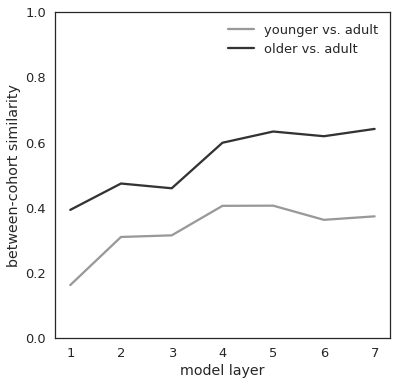

In [86]:
## Plot it
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,8),corYA,label='younger vs. adult',color=(0.6,0.6,0.6))
plt.plot(np.arange(1,8),corOA,label='older vs. adult',color=(0.2,0.2,0.2))
# plt.plot(np.arange(1,8),corKA,label='all kids vs. adult',color=(0.6,0.2,0.2))
plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()
plt.ylim(0,1)
plt.savefig('./plots/btw_cohort_similarity_noerrorbars.pdf')

#### Get errorbars for photo-sketch (jackknife resampling over classes) NOT DONE

In [87]:
## which layers
lb = 0
ub = 7
nIter = len(these_labels)

recomputeJacknife = 1
cohorts = ['younger','older']
CORMAT = []
if recomputeJacknife:
    for cohort in cohorts:
        ## loop through all kid layers and save out their RDM
        Cormat = [] ## cohort-level grouping of cross-cohort similarity
        for layer_num in np.arange(lb,ub):
            print 'Loading in kid features for layer {}...'.format(layer_num)    
            ## load in kid features
            KF, KM = load_features('kid',layer_num)
            KF, KM = remove_practice_trials(KF, KM)
            KM = KM.reset_index(drop=True)
            KF, KM = preproc_kid(KF, KM, these_labels)
            print 'Shape of kid feature tensor: {}'.format(np.shape(KF))    

            print 'Loading in adult features for layer {}...'.format(layer_num)
            AF, AM = load_features('adult',layer_num)
            AF, AM = remove_practice_trials(AF, AM)
            AM = AM.reset_index(drop=True)
            AF, AM = adult_preproc(AF, AM, these_labels)
            print 'Shape of adult feature tensor: {}'.format(np.shape(AF))           

            ## get older kid RDM
            print 'Getting and saving kid and adult RDMs ...'
            KRDM = []
            ARDM = []
            cormat = [] ## layer-level grouping of cross-cohort similarity
            for i in range(nIter):
                print 'Iteration {} of {}'.format(i,nIter)
                ## get RDM for this cohort, i.e., {'older', 'younger'}
                ind = KM.index[KM['coarse_age'] == cohort]
                meta = KM.loc[ind]
                feat = KF[ind.tolist()]                    
                krdm = get_RDM_resampled(meta, feat,sort_inds,i)
                ## get RDM adult for adults, aggregate across iterations
                ardm = get_RDM_resampled(AM, AF,sort_inds,i)        
                if len(KRDM)==0:
                    KRDM = krdm
                    ARDM = ardm
                else:
                    KRDM = np.dstack((KRDM,krdm))
                    ARDM = np.dstack((ARDM,ardm))                                  
                ## compute similarity between RDMs
                cormat.append(get_rdm_similarity(krdm,ardm))
            ## layer level aggregation    
            Cormat.append(cormat)
            KRDM = np.array(KRDM)
            ARDM = np.array(ARDM)
            np.save('./rdm/RDM_jackknife_{}_{}.npy'.format(cohort,layer_num),KRDM)             
            np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('adult',layer_num),ARDM)         
        ## cohort level aggregation    
        CORMAT.append(Cormat)
        
        ## save CORMAT 
        CORMAT = np.array(CORMAT)
        np.save('./rdm/CORMAT_JackknifedCohorts.npy',CORMAT)


Loading in kid features for layer 0...
Shape of kid feature tensor: (396, 64)
Loading in adult features for layer 0...
Shape of adult feature tensor: (2700, 64)
Getting and saving kid and adult RDMs ...
Iteration 0 of 27
Iteration 1 of 27
Iteration 2 of 27
Iteration 3 of 27
Iteration 4 of 27
Iteration 5 of 27
Iteration 6 of 27
Iteration 7 of 27
Iteration 8 of 27
Iteration 9 of 27
Iteration 10 of 27
Iteration 11 of 27
Iteration 12 of 27
Iteration 13 of 27
Iteration 14 of 27
Iteration 15 of 27
Iteration 16 of 27
Iteration 17 of 27
Iteration 18 of 27
Iteration 19 of 27
Iteration 20 of 27
Iteration 21 of 27
Iteration 22 of 27
Iteration 23 of 27
Iteration 24 of 27
Iteration 25 of 27
Iteration 26 of 27
Loading in kid features for layer 1...
Shape of kid feature tensor: (396, 128)
Loading in adult features for layer 1...
Shape of adult feature tensor: (2700, 128)
Getting and saving kid and adult RDMs ...
Iteration 0 of 27
Iteration 1 of 27
Iteration 2 of 27
Iteration 3 of 27
Iteration 4 of 27

Iteration 23 of 27
Iteration 24 of 27
Iteration 25 of 27
Iteration 26 of 27
Loading in kid features for layer 5...
Shape of kid feature tensor: (396, 4096)
Loading in adult features for layer 5...
Shape of adult feature tensor: (2700, 4096)
Getting and saving kid and adult RDMs ...
Iteration 0 of 27
Iteration 1 of 27
Iteration 2 of 27
Iteration 3 of 27
Iteration 4 of 27
Iteration 5 of 27
Iteration 6 of 27
Iteration 7 of 27
Iteration 8 of 27
Iteration 9 of 27
Iteration 10 of 27
Iteration 11 of 27
Iteration 12 of 27
Iteration 13 of 27
Iteration 14 of 27
Iteration 15 of 27
Iteration 16 of 27
Iteration 17 of 27
Iteration 18 of 27
Iteration 19 of 27
Iteration 20 of 27
Iteration 21 of 27
Iteration 22 of 27
Iteration 23 of 27
Iteration 24 of 27
Iteration 25 of 27
Iteration 26 of 27
Loading in kid features for layer 6...
Shape of kid feature tensor: (396, 4096)
Loading in adult features for layer 6...
Shape of adult feature tensor: (2700, 4096)
Getting and saving kid and adult RDMs ...
Iterati

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [123]:
if recomputeJacknife==0
    #  Load CORMAT if we didn't just compute it 
    CORMAT = np.load('./rdm/CORMAT_JackknifedCohorts.npy')

## CORMAT has dimensionality: num_cohorts x num_layers x num_categories
num_categories = np.shape(np.array(CORMAT))[2]
np.shape(np.array(CORMAT)) 

(2, 7, 27)

### Compute jacknife SEM based on simulations

In [124]:
## JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
# 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
# 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
#          where x.i = (1/n) * Sum(xi), the average of all subsamples 
cohorts = ['younger','older']
SEM_JACK = []

for c,cohort in enumerate(cohorts):
    sem_jack = []
    for layer_num in np.arange(7):
        jackvals = CORMAT[c,layer_num,:]
        jackmean = np.mean(jackvals)
        sem_jack.append(np.sqrt( (num_categories-1)/(num_categories) * np.array([(i-jackmean)**2 for i in jackvals]).sum()))
    SEM_JACK.append(sem_jack)
SEM_JACK = np.array(SEM_JACK)

### Compute adult-adult noise ceiling

In [113]:
## How many sketches do we have from each class in kids? Take this number, divide by 2, to get approx number 
## in adults for consistency analysis. Divide by 2, because we already are dividing kid drawing dataset
## into younger and older subcategories.

## edit Jan 30 2018: Bria asked about estimating adult-adult consistency in a way that is 
## directly comparable in terms of dataset size to the kid-adult RDM correlations.
## so to do this, we will estimate an RDM based on correlating noisy sub-sampled adult with 
## same rock-solid adult RDM on every go.

## load in kid dataset in order to get num kid drawings per class
YF, YM = load_features('kid',6)
kid_num_per_class = zip(np.unique(YM.label.values),np.round(YM.groupby('label').count()['age'].values/2))
knpc = dict(kid_num_per_class)
knpc['bicycle'] = knpc.pop('bike') # deal with naming inconsistency

##  initialize variables
CORR_noisy_rock_adult = [] 
CORR_noisy_noisy_adult = []

## 
num_layers=7
for layer_num in np.arange(num_layers):
    print('Layer {} of {}'.format(layer_num,num_layers))
    AF, AM = load_features('adult',layer_num)    
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)
    AF, AM = adult_preproc(AF, AM, these_labels)    
    qats = np.unique(AM.label.values)
    nIter = 10

    noisy_rock_adult_sims = [] ## correlation between split RDM's
    noisy_noisy_adult_sims = [] ## correlation between small RDM and noisy RDM
    
    ## load in rock-solid RDM estimated on 100 drawings per class
    adult_rock_RDM = []
    adult_rock_RDM = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num)) 
    
                             
    for it in np.arange(nIter):
        Meta = [] # initialize adult subsampled metadata csv -- same for both halves
        Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
        Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half
        if it%5==0:
            print('Iteration {} of {}'.format(it,nIter))
        for q in qats:
            ind = AM.index[AM['label'] == q] # get indexes
            meta = AM.loc[ind] # get metadata for this category
            meta = meta.reset_index(drop=True)
            feat = AF[ind.tolist()] # get features for this category
            how_many = int(knpc[q]) ## look up approx(!) how many younger/older kid sketches we have from this class

            ## Randomly sample
            row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
            metasamp = meta.loc[row_inds]
            featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

            row_inds_2 = np.random.RandomState(it).permutation(meta.shape[0])[how_many*2:how_many*3] ## get the next drawings in the permuted list
            featsamp2 = feat[row_inds_2.tolist()] ## subsample second "split-half" feature mat
            metasamp2 = meta.loc[row_inds_2]

            if len(Meta)==0:        
                Meta = metasamp
                Feat1 = featsamp
                Feat2 = featsamp2
            else:
                Meta = pd.concat((Meta,metasamp))
                Feat1 = np.vstack((Feat1,featsamp)) 
                Feat2 = np.vstack((Feat2,featsamp2))
            
        ## get class means        
        Meta = Meta.reset_index(drop=True)
        print np.shape(Feat1)
        means1 = get_class_means(Feat1, Meta.label.values)
        means2 = get_class_means(Feat2, Meta.label.values)

        ## get RDM for each half
        rdm1 = get_RDM(Meta,Feat1,sort_inds)
        rdm2 = get_RDM(Meta,Feat2,sort_inds)
                
        dim = rdm1.shape[0]
        noisy_rock_adult = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]), \
                              np.ravel(adult_rock_RDM[np.triu_indices(dim,k=1)]))[0]
        noisy_noisy_adult = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]), \
                              np.ravel(rdm2[np.triu_indices(dim,k=1)]))[0]
        noisy_rock_adult_sims.append(noisy_rock_adult)
        noisy_noisy_adult_sims.append(noisy_noisy_adult)
    CORR_noisy_rock_adult.append(noisy_rock_adult_sims)
    CORR_noisy_noisy_adult.append(noisy_noisy_adult_sims)

Layer 0 of 7
Iteration 0 of 10
(196, 64)
(196, 64)
(196, 64)
(196, 64)
(196, 64)
Iteration 5 of 10
(196, 64)
(196, 64)
(196, 64)
(196, 64)
(196, 64)
Layer 1 of 7
Iteration 0 of 10
(196, 128)
(196, 128)
(196, 128)
(196, 128)
(196, 128)
Iteration 5 of 10
(196, 128)
(196, 128)
(196, 128)
(196, 128)
(196, 128)
Layer 2 of 7
Iteration 0 of 10
(196, 256)
(196, 256)
(196, 256)
(196, 256)
(196, 256)
Iteration 5 of 10
(196, 256)
(196, 256)
(196, 256)
(196, 256)
(196, 256)
Layer 3 of 7
Iteration 0 of 10
(196, 512)
(196, 512)
(196, 512)
(196, 512)
(196, 512)
Iteration 5 of 10
(196, 512)
(196, 512)
(196, 512)
(196, 512)
(196, 512)
Layer 4 of 7
Iteration 0 of 10
(196, 512)
(196, 512)
(196, 512)
(196, 512)
(196, 512)
Iteration 5 of 10
(196, 512)
(196, 512)
(196, 512)
(196, 512)
(196, 512)
Layer 5 of 7
Iteration 0 of 10
(196, 4096)
(196, 4096)
(196, 4096)
(196, 4096)
(196, 4096)
Iteration 5 of 10
(196, 4096)
(196, 4096)
(196, 4096)
(196, 4096)
(196, 4096)
Layer 6 of 7
Iteration 0 of 10
(196, 4096)
(19

In [115]:
## save out average values & rename variables
adult_noisy_rock_layerwise = np.asarray(CORR_noisy_rock_adult)
adult_noisy_noisy_layerwise = np.asarray(CORR_noisy_noisy_adult)
np.save('./rdm/adult_noisy_rock_layerwise_archive.npy',adult_noisy_rock_layerwise)  
np.save('./rdm/adult_noisy_noisy_layerwise_archive.npy',adult_noisy_noisy_layerwise)  

### Jackknife resampling on class for noisy adult

In [116]:
###### jackknife resampling on class for noisy adult -- rock-solid adult RDM similarity
lb = 0
ub = 7
nIter = len(these_labels)
Cormat = [] 

for layer_num in np.arange(lb,ub):
    ARDM = [] 
    NARDM = []
    
    ### loading in all adult features
    print 'Loading in adult features for layer {}...'.format(layer_num)
    AF, AM = load_features('adult',layer_num)
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)
    AF, AM = adult_preproc(AF, AM, these_labels)
    print 'Shape of adult feature tensor: {}'.format(np.shape(AF)) 

    ## get categories
    qats = np.unique(AM.label.values)
    nIter = 1

    Cor = [] ## correlation between split RDM's
    for it in np.arange(nIter):
        Meta = [] # initialize adult subsampled metadata csv -- same for both halves
        Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
        Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half
        if it%5==0:
            print('Iteration {} of {}'.format(it,nIter))
        for q in qats:
            ind = AM.index[AM['label'] == q]
            meta = AM.loc[ind]
            meta = meta.reset_index(drop=True)
            feat = AF[ind.tolist()]

            how_many = int(knpc[q]) ## look up approx(!) how many younger/older kid sketches we have from this class
            row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
            metasamp = meta.loc[row_inds]
            featsamp = feat[row_inds.tolist()] ## subsample "split-half" feature mat

            if len(Meta)==0:
                Meta = metasamp
                Feat1 = featsamp
            else:
                Meta = pd.concat((Meta,metasamp))
                Feat1 = np.vstack((Feat1,featsamp)) 

        ## define feature matrix and metadata         
        NAM = Meta.reset_index(drop=True)
        NAF = Feat1
        print 'Shape of adult feature tensor: {}'.format(np.shape(NAF)) 

        ## jackknife resample through classes
        print 'Performing jackknife resampling ...'
        ARDM = []
        NARDM = []
        cormat = [] ## layer-level grouping of cross-cohort similarity
        num_cats = 27
        for i in range(num_cats):
            if i%4==0:
                print 'Iteration {} of {}'.format(i,num_cats)

            ## get RDM adult for adults, aggregate across iterations
            nardm = get_RDM_resampled(NAM, NAF,sort_inds,i) 
            ardm = get_RDM_resampled(AM,AF,sort_inds,i)
            if len(ARDM)==0:
                ARDM = ardm
                NARDM = nardm
            else:
                ARDM = np.dstack((ARDM,ardm))   
                NARDM = np.dstack((NARDM,nardm)) 
                
            ## compute similarity between noisy-adult RDM and rock-solid RDM                                                
            cormat.append(get_rdm_similarity(nardm,ardm))
            
        ## layer level aggregation    
        Cormat.append(cormat)
        ARDM = np.array(ARDM)  
        NARDM = np.array(NARDM)
        
        ## save out jackknifed RDM        
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('noisy_adult',layer_num),NARDM)  
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('adult_micro',layer_num),ARDM)

Cormat = np.array(Cormat)                      

Loading in adult features for layer 0...
Shape of adult feature tensor: (2700, 64)
Iteration 0 of 1
Shape of adult feature tensor: (196, 64)
Performing jackknife resampling ...
Iteration 0 of 27
Iteration 4 of 27
Iteration 8 of 27
Iteration 12 of 27
Iteration 16 of 27
Iteration 20 of 27
Iteration 24 of 27
Loading in adult features for layer 1...
Shape of adult feature tensor: (2700, 128)
Iteration 0 of 1
Shape of adult feature tensor: (196, 128)
Performing jackknife resampling ...
Iteration 0 of 27
Iteration 4 of 27
Iteration 8 of 27
Iteration 12 of 27
Iteration 16 of 27
Iteration 20 of 27
Iteration 24 of 27
Loading in adult features for layer 2...
Shape of adult feature tensor: (2700, 256)
Iteration 0 of 1
Shape of adult feature tensor: (196, 256)
Performing jackknife resampling ...
Iteration 0 of 27
Iteration 4 of 27
Iteration 8 of 27
Iteration 12 of 27
Iteration 16 of 27
Iteration 20 of 27
Iteration 24 of 27
Loading in adult features for layer 3...
Shape of adult feature tensor: (27

#### Recreate averages and sems from jacknifed samples


In [119]:
lb = 0
ub = 7
iteration = 27
# intialize
older_younger = np.zeros((ub,iteration))
noisy_micro = np.zeros((ub,iteration))
older_noisy_adult = np.zeros((ub,iteration))
younger_noisy_adult = np.zeros((ub,iteration))
older_micro_adult = np.zeros((ub,iteration))
younger_micro_adult = np.zeros((ub,iteration))

for layer_num in np.arange(lb,ub):
    YRDM = np.load('./rdm/RDM_jackknife_younger_{}.npy'.format(layer_num))
    ORDM = np.load('./rdm/RDM_jackknife_older_{}.npy'.format(layer_num))
    NARDM = np.load('./rdm/RDM_jackknife_noisy_adult_{}.npy'.format(layer_num))
    ARDM = np.load('./rdm/RDM_jackknife_adult_micro_{}.npy'.format(layer_num))
    
    for iteration in np.arange(0,27):
        yrdm = YRDM[:,:,iteration]
        ordm = ORDM[:,:,iteration]
        nardm = NARDM[:,:,iteration]
        ardm = ARDM[:,:,iteration]
        
        older_younger[layer_num, iteration] = get_rdm_similarity(yrdm,ordm)
        noisy_micro[layer_num, iteration] = get_rdm_similarity(ardm,nardm)
        
        older_noisy_adult[layer_num, iteration] = get_rdm_similarity(ordm,nardm)
        younger_noisy_adult[layer_num, iteration] = get_rdm_similarity(yrdm,nardm)
        
        older_micro_adult[layer_num, iteration] = get_rdm_similarity(ordm,ardm)
        younger_micro_adult[layer_num, iteration] = get_rdm_similarity(yrdm,ardm)
        
def get_jacknife_sem(cormat,num_categories):
    sem_jack = []
    for layer_num in np.arange(7):
        jackvals = cormat[layer_num,:]
        jackmean = np.mean(jackvals)
        sem_jack.append(np.sqrt( (num_categories-1)/(num_categories) * np.array([(i-jackmean)**2 for i in jackvals]).sum()))
    sem_jack=np.asarray(sem_jack)
    return sem_jack

num_categories = 27
older_younger_sem = get_jacknife_sem(older_younger,num_categories)
noisy_micro_sem = get_jacknife_sem(noisy_micro,num_categories)   
older_noisy_adult_sem = get_jacknife_sem(older_noisy_adult,num_categories)   
younger_noisy_adult_sem = get_jacknife_sem(younger_noisy_adult,num_categories)   
older_micro_adult_sem = get_jacknife_sem(older_micro_adult,num_categories)   
younger_micro_adult_sem = get_jacknife_sem(younger_micro_adult,num_categories)   

#### Make final plot and save out averages

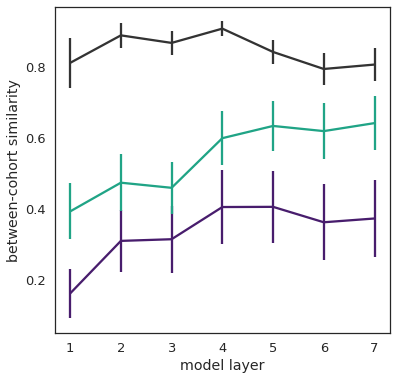

In [120]:
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
younger_color = [72/255, 29/255, 109/255]
older_color=[32/255, 164/255, 134/255]

# kids vs rock adults
h = plt.errorbar(np.arange(1,8),younger_micro_adult.mean(1),yerr=[younger_micro_adult_sem,younger_micro_adult_sem], color=younger_color, ecolor=younger_color,label='younger vs. rock-solid adult')
h = plt.errorbar(np.arange(1,8),older_micro_adult.mean(1),yerr=[older_micro_adult_sem,older_micro_adult_sem], color=older_color, ecolor=older_color,label='older vs. rock-solid adult')

# kids vs noisy adults
# h = plt.errorbar(np.arange(1,8),younger_noisy_adult.mean(1),yerr=[younger_noisy_adult_sem,younger_noisy_adult_sem], color=[0.6, 0.6, 0.8], ecolor=[0.6, 0.6, 0.8],label='younger vs. noisy adult')
# h = plt.errorbar(np.arange(1,8),older_noisy_adult.mean(1),yerr=[older_noisy_adult_sem,older_noisy_adult_sem], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.4],label='older vs. noisy adult')

# adults v adults
h = plt.errorbar(np.arange(1,8),noisy_micro.mean(1),yerr=[noisy_micro_sem,noisy_micro_sem], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.2],label='noisy vs. rock-solid adult')

# younger vs older kids
# h = plt.errorbar(np.arange(1,8),older_younger.mean(1),yerr=[older_younger_sem,older_younger_sem], color=[0.2, 0.2, 0.6], ecolor=[0.2, 0.2, 0.6],label='older vs. younger kids ')


plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
# plt.legend()
plt.savefig('./plots/btw_cohort_similarity_noiseceiling.pdf')

In [121]:
older_micro_adult.mean(1)

array([ 0.39185093,  0.4725315 ,  0.45816176,  0.59760277,  0.63195731,
        0.61747263,  0.63991577])

In [122]:
## save out cohort similarity csv for plotting in R
df = pd.DataFrame({
    'CorrYoungAdult':  younger_micro_adult.mean(1),
    'SEMYoungAdult':younger_micro_adult_sem,
    'CorrOldAdult':  older_micro_adult.mean(1),
    'SEMOldAdult':  older_micro_adult_sem,
    'CorrAdultAdult':  noisy_micro.mean(1),
    'SEMAdultAdult':  noisy_micro_sem,
})
df.to_csv('./outputs-cogsci/CohortSimilarity_VGG19_27x27.csv') 

In [ ]:
plt.matshow(NARDM_1[:,:,1])
plt.colorbar()

plt.matshow(ARDM_1[:,:,1])
plt.colorbar()

plt.matshow(YRDM_1[:,:,1])
plt.colorbar()

plt.matshow(ORDM_1[:,:,1])
plt.colorbar()